<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-0:-Get-to-Know-the-Data" data-toc-modified-id="Part-0:-Get-to-Know-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Part 0: Get to Know the Data</a></span><ul class="toc-item"><li><span><a href="#Fixing-the-categorical-variables-and-memory-usage" data-toc-modified-id="Fixing-the-categorical-variables-and-memory-usage-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fixing the categorical variables and memory usage</a></span></li><li><span><a href="#Ranking-customers-labels" data-toc-modified-id="Ranking-customers-labels-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ranking customers labels</a></span></li><li><span><a href="#Cleanup-of-incomplete-data-(missing-values)" data-toc-modified-id="Cleanup-of-incomplete-data-(missing-values)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Cleanup of incomplete data (missing values)</a></span></li><li><span><a href="#Impute-the-missing-values" data-toc-modified-id="Impute-the-missing-values-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Impute the missing values</a></span></li></ul></li><li><span><a href="#Part-1:-Customer-Segmentation-Report" data-toc-modified-id="Part-1:-Customer-Segmentation-Report-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part 1: Customer Segmentation Report</a></span></li><li><span><a href="#Part-2:-Supervised-Learning-Model" data-toc-modified-id="Part-2:-Supervised-Learning-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part 2: Supervised Learning Model</a></span><ul class="toc-item"><li><span><a href="#Linear-support-vector-(for-comparison)" data-toc-modified-id="Linear-support-vector-(for-comparison)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear support vector (for comparison)</a></span></li><li><span><a href="#Balanced-Random-Forest-Classifier" data-toc-modified-id="Balanced-Random-Forest-Classifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Balanced Random Forest Classifier</a></span></li><li><span><a href="#Deep-learning-approach" data-toc-modified-id="Deep-learning-approach-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Deep learning approach</a></span></li></ul></li><li><span><a href="#Part-3:-Kaggle-Competition" data-toc-modified-id="Part-3:-Kaggle-Competition-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Part 3: Kaggle Competition</a></span></li></ul></div>

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import warnings
import pickle
import aid_functions as af

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, plot_roc_curve, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

# for data preprocessing and clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from skorch import NeuralNetClassifier

# to include graphs inline within the frontends next to code
%matplotlib inline

%reload_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./Data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('./Data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [3]:
print(azdias.info())
azdias.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

### Fixing the categorical variables and memory usage
We want to remove any unnecessary object column in our dataframes.
It is important to correctly identify the categorical features in order to be able to one hot encode them and obtain better results in machine learning models at a later time.

The memory requirement is very high, most values are integers and range within few tens. Many columns are set to float type due to presence of NaNs.

The object columns are:

In [5]:
azdias.select_dtypes('object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


We can drop because not relevant: LNR, EINGEFUEGT_AM. The others will be either converted or turned into dummies.

In [6]:
azdias.drop(["LNR", "EINGEFUEGT_AM"], axis=1, inplace=True, errors='ignore')

In [7]:
azdias.CAMEO_DEUG_2015.value_counts()

8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
X       373
Name: CAMEO_DEUG_2015, dtype: int64

In [8]:
azdias.CAMEO_INTL_2015.value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
XX       373
Name: CAMEO_INTL_2015, dtype: int64

We remove the unknown X and XX by replacing them with -1.

In [9]:
azdias.CAMEO_DEUG_2015 = azdias.CAMEO_DEUG_2015.replace('X', -1).astype('float16')
azdias.CAMEO_INTL_2015 = azdias.CAMEO_INTL_2015.replace('XX', -1).astype('float16')

We reduce the memory usage (float because of the presence of Nan values).

In [10]:
azdias = azdias.astype('float16', errors='ignore')

### Ranking customers labels  
At first we can try to get an idea of the most recurring features of our customers per each column.

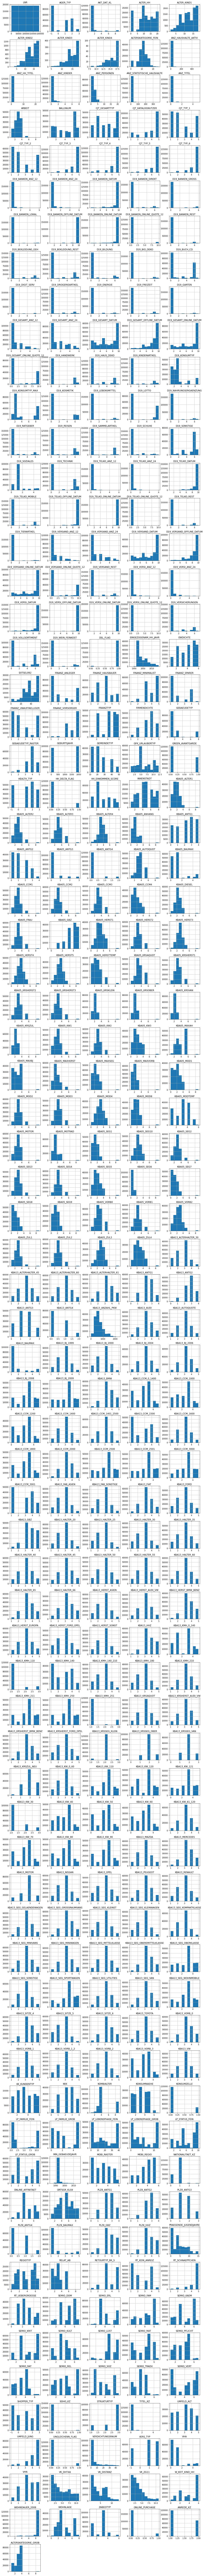

In [11]:
customers.iloc[:,:].hist(figsize=(18,250), layout=(int(len(customers.columns)/5),5));

**Observation**  
A lot of entries contain many 0s, -1s and 9s. According to attached DIAS attribute file, each group of categories adopts a different set of values for NA information. To normalize the data, it is necessary to get the same value for every missing information.

### Cleanup of incomplete data (missing values)  
We need to verify if any data is missing and reduce the number of columns accordingly in order to reduce data usage and complexity.  We will drop any column with few entries (< 60%), since it won't add much information. The other columns will be imputed with the mode.

---
Depending on the parameter, 0, -1, or 9 can also have different meanings, so we select the columns out of the first filter manually.  
The following values mean unknown (NaN):

- **0** : AGER_TYP, ALTERSKATEGORIE_GROB, ALTER_HH, ANREDE_KZ, CJT_GESAMTTYP, GEBAEUDETYP, GEOSCORE_KLS7, HAUSHALTSSTRUKTUR, HH_EINKOMMEN_SCORE, KBA05_\*, KKK, NATIONALITAET_KZ, PRAEGENDE_JUGENDJAHRE, REGIOTYP, RETOURTYP_BK_S, TITEL_KZ, WOHNDAUER_2008, WACHSTUMSGEBIET_NB, W_KEIT_KIND_HH
  
  
- **-1** : AGER_TYP, ALTERSKATEGORIE_GROB, ANREDE_KZ, BALLRAUM, BIP_FLAG, CAMEO_DEUG_2015, CAMEO_INTL_2015, D19_KK_KUNDENTYP, EWDICHTE, FINANZTYP, FINANZ_\*, GEBAEUDETYP, GEOSCORE_KLS7, HAUSHALTSSTRUKTUR, HEALTH_TYP, HH_EINKOMMEN_SCORE, INNENSTADT, KBA05_\*, KBA13_\*, KKK, NATIONALITAET_KZ, ORTSGR_KLS9, OST_WEST_KZ, PLZ8_\*, PRAEGENDE_JUGENDJAHRE, REGIOTYP, SEMIO_\*, SHOPPER_TYP, SOHO_KZ, TITEL_KZ, VERS_TYP, WOHNDAUER_2008, WOHNLAGE, WACHSTUMSGEBIET_NB, W_KEIT_KIND_HH, ZABEOTYP
  
  
- **9** : KBA05_\*, SEMIO_\*, ZABEOTYP  

We are going to replace all these values with NaN.

In [12]:
set_0 = 'AGER_TYP, ALTERSKATEGORIE_GROB, ALTER_HH, ANREDE_KZ, CJT_GESAMTTYP, GEBAEUDETYP, GEOSCORE_KLS7, HAUSHALTSSTRUKTUR, HH_EINKOMMEN_SCORE, KBA05_*, KKK, NATIONALITAET_KZ, PRAEGENDE_JUGENDJAHRE, REGIOTYP, RETOURTYP_BK_S, TITEL_KZ, WOHNDAUER_2008, WACHSTUMSGEBIET_NB, W_KEIT_KIND_HH'.split(', ')
set_neg1 = 'AGER_TYP, ALTERSKATEGORIE_GROB, ANREDE_KZ, BALLRAUM, BIP_FLAG, CAMEO_DEUG_2015, CAMEO_INTL_2015, D19_KK_KUNDENTYP, EWDICHTE, FINANZTYP, FINANZ_*, GEBAEUDETYP, GEOSCORE_KLS7, HAUSHALTSSTRUKTUR, HEALTH_TYP, HH_EINKOMMEN_SCORE, INNENSTADT, KBA05_*, KBA13_*, KKK, NATIONALITAET_KZ, ORTSGR_KLS9, OST_WEST_KZ, PLZ8_*, PRAEGENDE_JUGENDJAHRE, REGIOTYP, SEMIO_*, SHOPPER_TYP, SOHO_KZ, TITEL_KZ, VERS_TYP, WOHNDAUER_2008, WOHNLAGE, WACHSTUMSGEBIET_NB, W_KEIT_KIND_HH, ZABEOTYP'.split(', ')
set_9 = 'KBA05_*, SEMIO_*, ZABEOTYP'.split(', ')

af.replace_values_in_df(azdias, set_0, 0)
af.replace_values_in_df(azdias, set_neg1, -1)
af.replace_values_in_df(azdias, set_9, 9)

A further issue is that many numerical features are just ordinal encoders and therefore would be best set as categorical features in order to one-hot encode them for later machine learning models.  
The best strategy would be to at first ordinal encode the categorical data left in order to impute the missing categories and only after that one hot encode all the categorical features.

We first turn residual categorical features into ordinal (numerical), then run the imputer. After that we must one hot encode the imputed categorical features.

In [13]:
ordinal_enc = OrdinalEncoder().fit(azdias.select_dtypes('object').replace(np.nan, 'nan'))
object_ordinals = pd.DataFrame(ordinal_enc.transform(azdias.select_dtypes('object').replace(np.nan, 'nan'))).astype('int')

In [14]:
# we put back in the nan values
nan_list = ordinal_enc.transform(np.array([['nan', 'nan', 'nan']]))
for i in range(3):
    object_ordinals.iloc[:,i] = object_ordinals.iloc[:,i].replace(nan_list[0,i], np.nan)

for i, col in enumerate(azdias.select_dtypes('object').columns):
    azdias[col] = object_ordinals.iloc[:,i]

In [15]:
# we want to selectively drop the columns from costumers which contain not much useful data (unknown or missing)
azdias_cols_to_drop = af.columns_over_threshold(azdias, 70)

AGER_TYP: 76.96%
ALTER_KIND1: 90.90%
ALTER_KIND2: 96.69%
ALTER_KIND3: 99.31%
ALTER_KIND4: 99.86%
EXTSEL992: 73.40%
KBA05_ANTG3: 72.36%
KBA05_ANTG4: 82.30%
KBA05_SEG6: 90.07%
TITEL_KZ: 99.76%
10 columns contain more than 70% of [nan].



In [16]:
try:
    pd.get_dummies(azdias.select_dtypes('object'), drop_first=True)
except:
    pass

In [17]:
# Remove the columns with too many NaNs
azdias.drop(azdias_cols_to_drop, axis=1, inplace=True, errors='ignore')

The features which can be interpreted as categorical are the following ones.

- AGER_TYP, ALTERSKATEGORIE_GROB, ANREDE_KZ, CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015, CJT_GESAMTTYP, KK_KUNDENTYP, FINANZTYP, GEBAEUDETYP, GREEN_AVANTGARDE, HEALTH_TYP, KBA05_HERSTTEMP, KBA05_MAXHERST, KBA05_MAXVORB, KBA05_MODTEMP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, OST_WEST_KZ, PRAEGENDE_JUGENDJAHRE, REGIOTYP, RETOURTYP_BK_S, SHOPPER_TYP, SOHO_KZ, TITEL_KZ, VERS_TYP, WOHNLAGE, ZABEOTYP

- UNGLEICHENN_FLAG, DSL_FLAG, HH_DELTA_FLAG, KBA05_SEG6, KONSUMZELLE

- D19_*_RZ

In [18]:
D19_categories = [col for col in azdias.columns if (
    col.startswith('D19')
    and not (col.endswith('ANZ_12'))
    and not (col.endswith('ANZ_24'))
    and not (col.endswith('DATUM'))
    and not (col.endswith('QUOTE_12'))
)]

cat_features = 'AGER_TYP, ALTERSKATEGORIE_GROB, ANREDE_KZ, CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015, CJT_GESAMTTYP, KK_KUNDENTYP, FINANZTYP, GEBAEUDETYP, GREEN_AVANTGARDE, HEALTH_TYP, KBA05_HERSTTEMP, KBA05_MAXHERST, KBA05_MAXVORB, KBA05_MODTEMP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, OST_WEST_KZ, PRAEGENDE_JUGENDJAHRE, REGIOTYP, RETOURTYP_BK_S, SHOPPER_TYP, SOHO_KZ, TITEL_KZ, VERS_TYP, WOHNLAGE, ZABEOTYP, UNGLEICHENN_FLAG, DSL_FLAG, HH_DELTA_FLAG, KBA05_SEG6, KONSUMZELLE'.split(
    ', ')
cat_features = [cat for cat in cat_features if cat in azdias.columns]

for cat in D19_categories:
    cat_features.append(cat)

### Impute the missing values

For the categorical columns we are going to make dummy columns, while for the numerical columns we are going to impute the missing values through ....

In [19]:
# get columns in both dataframes for imputer
union_columns = list(azdias.select_dtypes('number').columns.intersection(customers.columns))
# get numerical columns not in azdias
customers_only = list(customers.select_dtypes('number').columns.difference(azdias.columns))

In [20]:
# Create the imputer and fit it
imputer = IterativeImputer(n_nearest_features=4, initial_strategy='most_frequent')
imputer.fit(azdias[union_columns])

IterativeImputer(initial_strategy='most_frequent', n_nearest_features=4)

In [21]:
azdias_imputed = af.impute_dataframe(azdias, imputer)
#customers_imputed = impute_dataframe(customers, imputer, union_columns)
#customers_imputed = pd.concat([customers[customers_only], customers_imputed], axis=1)

In [22]:
azdias_imputed = azdias_imputed.round().apply(pd.to_numeric, downcast='unsigned', errors='ignore')

In [23]:
# Get dummies for selected categorical features
azdias_imputed = pd.get_dummies(azdias_imputed, columns=cat_features, drop_first=True)

In [24]:
# Reduce memory usage
azdias_imputed = azdias_imputed.apply(pd.to_numeric, downcast='unsigned', errors='ignore')

In [25]:
pickle.dump( imputer, open( "imputer.pickle", "wb" ) )
pickle.dump( azdias_imputed, open( "azdias_imputed.pickle", "wb" ) )
pickle.dump( azdias_cols_to_drop, open( "azdias_cols_to_drop.pickle", "wb" ) )

We can now refactor the clean up of the data into a pipeline for later usage. See aid_functions.py.


In [26]:
azdias_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 840 entries, AKT_DAT_KL to D19_WEIN_FEINKOST_7
dtypes: float64(4), uint16(6), uint8(830)
memory usage: 742.8 MB


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [28]:
azdias_scaled = af.get_scaled_df(azdias_imputed)

In [30]:
pca = PCA().fit(azdias_scaled)

In [31]:
pca.explained_variance_ratio_

array([8.22066160e-02, 5.43039464e-02, 5.00693761e-02, 3.83685126e-02,
       2.61035951e-02, 2.08347743e-02, 1.97461145e-02, 1.83282144e-02,
       1.67299297e-02, 1.57390909e-02, 1.52334284e-02, 1.37581245e-02,
       1.26116343e-02, 1.12330729e-02, 1.09411560e-02, 1.03942018e-02,
       1.02306436e-02, 9.77093470e-03, 9.20052741e-03, 9.07050842e-03,
       8.55777197e-03, 8.50740369e-03, 8.18535843e-03, 7.75304907e-03,
       7.49185859e-03, 7.35762552e-03, 7.14132515e-03, 7.02135138e-03,
       6.57763085e-03, 6.45858481e-03, 6.44569213e-03, 6.04009868e-03,
       5.92548541e-03, 5.76453021e-03, 5.64667205e-03, 5.53991126e-03,
       5.43516089e-03, 5.39348101e-03, 5.30026231e-03, 5.23468209e-03,
       5.08584280e-03, 4.89899851e-03, 4.75072044e-03, 4.69251825e-03,
       4.65426560e-03, 4.60944986e-03, 4.50040756e-03, 4.40419053e-03,
       4.34252589e-03, 4.27464485e-03, 4.17665624e-03, 4.03046522e-03,
       3.96372619e-03, 3.86517926e-03, 3.83881531e-03, 3.75796769e-03,
      

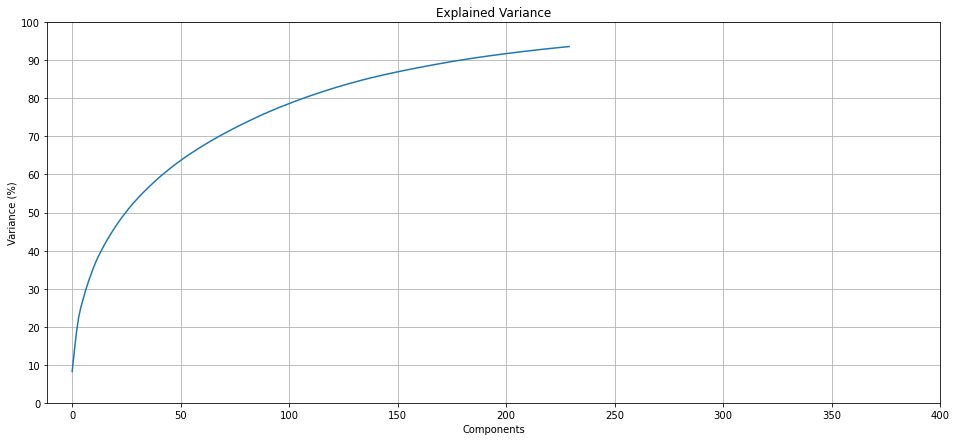

In [39]:
#Explained Variance
plt.figure(figsize=(16, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Components'); plt.xticks(np.arange(0, 450, step=50));
plt.ylabel('Variance (%)'); plt.yticks(np.arange(0, 110, step=10));
plt.title('Explained Variance')
plt.grid()

From the plot it can be seen that a 90% of the variance explanation can be preserved by selecting 170 components. Therefore we reduce the PCA to this number of components.

In [33]:
pca = PCA(n_components=170).fit(azdias_scaled)
azdias_reduced = pca.transform(azdias_scaled)

In [34]:
# We can verify the correlation of a component to the features by verifying the distance from 0
component = 0

pca_df = pd.DataFrame(pca.components_, columns=list(azdias_scaled.columns))
print(pca_df.iloc[component].sort_values(ascending=False))

PLZ8_ANTG1         0.154264
KBA13_ANTG1        0.153117
MOBI_REGIO         0.150482
KBA13_AUTOQUOTE    0.141448
MOBI_RASTER        0.141340
                     ...   
PLZ8_ANTG4        -0.148370
KBA05_BAUMAX      -0.150018
KBA13_ANTG4       -0.150687
KBA13_ANTG3       -0.154640
PLZ8_ANTG3        -0.155339
Name: 0, Length: 840, dtype: float64


Now a clustering method such as k-means can be used to verify how the data positions itself in the principal components space. We're going to use the elbow method as mentioned here: https://www.geeksforgeeks.org/ml-determine-the-optimal-value-of-k-in-k-means-clustering/#:~:text=There%20is%20a%20popular%20method,fewer%20elements%20in%20the%20cluster.

In [35]:
k_to_explore = range(1, 21)
azdias_red_sample = pd.DataFrame(azdias_reduced).sample(frac=0.1, random_state=1)

In [36]:
cost =[] 
for i in k_to_explore: 
    print(f'Processing for {i} cluster(s).')
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(azdias_red_sample)
    
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)

Processing for 1 cluster(s).
Processing for 2 cluster(s).
Processing for 3 cluster(s).
Processing for 4 cluster(s).
Processing for 5 cluster(s).
Processing for 6 cluster(s).
Processing for 7 cluster(s).
Processing for 8 cluster(s).
Processing for 9 cluster(s).
Processing for 10 cluster(s).
Processing for 11 cluster(s).
Processing for 12 cluster(s).
Processing for 13 cluster(s).
Processing for 14 cluster(s).
Processing for 15 cluster(s).
Processing for 16 cluster(s).
Processing for 17 cluster(s).
Processing for 18 cluster(s).
Processing for 19 cluster(s).
Processing for 20 cluster(s).


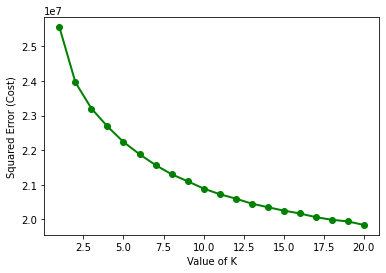

In [37]:
# plot the cost against K values 
plt.plot(k_to_explore, cost, '-o', color ='g', linewidth ='2') 
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)") 
plt.show() # clear the plot 

# the point of the elbow is the 
# most optimal value for choosing k 

We select the elbow at 10 clusters and compute the clustering for the full dataframe.

In [38]:
union_columns = list(azdias_imputed.select_dtypes('number').columns.intersection(customers_imputed.columns))
customers_reduced = pca.transform(scaler.transform(customers_imputed[union_columns]))

NameError: name 'customers_imputed' is not defined

In [ ]:
kmeans = KMeans(n_clusters = 10, max_iter = 500).fit(azdias_reduced)

In [ ]:
azdias_predict = kmeans.predict(azdias_reduced)
customers_predict = kmeans.predict(customers_reduced)

In [ ]:
azdias_reduced=pd.DataFrame(azdias_reduced)
customers_reduced=pd.DataFrame(customers_reduced)
azdias_predict=pd.DataFrame(azdias_predict)
customers_predict=pd.DataFrame(customers_predict)

In [ ]:
azdias_cluster = azdias_predict.value_counts().sort_index()/len(azdias_predict)*100
customers_cluster = customers_predict.value_counts().sort_index()/len(customers_predict)*100

clusters = pd.DataFrame({'azdias': azdias_cluster.values, 'customers': customers_cluster.values})

clusters.hvplot.bar(height=500, width=900, rot=90, xlabel='Cluster nr.', ylabel='% of dataset')

In [ ]:
pickle.dump( kmeans, open( "kmeans.pickle", "wb" ) )
pickle.dump( pca, open( "pca.pickle", "wb" ) )
pickle.dump( scaler, open( "scaler.pickle", "wb" ) )

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
mailout_train = pd.read_csv('./Data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train_response = mailout_train.pop('RESPONSE')

In [3]:
imputer = pickle.load( open( "imputer.pickle", "rb" ) )
kmeans = pickle.load( open( "kmeans.pickle", "rb" ) )
pca = pickle.load( open( "pca.pickle", "rb" ) )
scaler = pickle.load( open( "scaler.pickle", "rb" ) )
azdias_cols_to_drop = pickle.load( open( "azdias_cols_to_drop.pickle", "rb" ) )

We use the refactored function to quickly process the new dataset.

In [4]:
mailout_train_clean = af.clean_df(mailout_train, imputer, azdias_cols_to_drop)

In [5]:
print(mailout_train_clean.shape, mailout_train_response.mean())

(42962, 428) 0.012383036171500396


In [6]:
mailout_train_clean

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_W
0,1,8,8,15,0,0,1,13.0,0,3,...,0,0,0,0,1,0,0,0,0,1
1,4,13,13,1,0,0,2,1.0,0,2,...,0,1,0,0,0,0,0,0,0,1
2,1,9,7,0,0,0,0,1.0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,1,6,6,4,0,0,2,4.0,0,4,...,0,0,0,0,1,0,0,0,0,1
4,1,9,9,53,0,0,1,44.0,0,3,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,1,12,10,1,0,0,2,2.0,0,1,...,0,0,0,0,0,0,0,0,0,1
42958,1,14,14,1,0,0,2,1.0,0,4,...,0,0,0,0,0,0,0,0,0,0
42959,1,16,10,2,0,0,3,2.0,0,1,...,0,0,0,0,0,0,0,0,0,1
42960,1,18,13,3,0,0,3,2.0,0,2,...,0,0,0,0,0,0,0,0,0,1


In [8]:
scaler = StandardScaler()
mailout_train_clean = scaler.fit_transform(mailout_train_clean)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(mailout_train_clean, mailout_train_response, test_size=0.3, random_state=1)
X_train.shape

(30073, 428)

In [10]:
y_train.value_counts()

0    29685
1      388
Name: RESPONSE, dtype: int64

We can see that the available data is heavily imbalanced. Therefore it is best to proceed with resampling techniques.

### Linear support vector (for comparison)

In [11]:
svm_model = LinearSVC(random_state=10)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

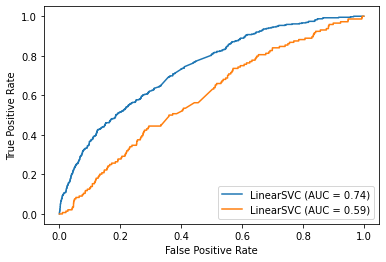

In [12]:
ax = plt.gca()
plot_roc_curve(svm_model, X_train, y_train, ax=ax)
plot_roc_curve(svm_model, X_test, y_test, ax=ax);

In [ ]:
X_train

### Balanced Random Forest Classifier

In [13]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [18]:
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [
    ('over', SMOTE()),
    #('under', RandomUnderSampler()),
    ('model', BalancedRandomForestClassifier())
]

pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     12745
           1       0.02      0.04      0.03       144

    accuracy                           0.97     12889
   macro avg       0.50      0.51      0.50     12889
weighted avg       0.98      0.97      0.97     12889

0    12585
1      304
dtype: int64


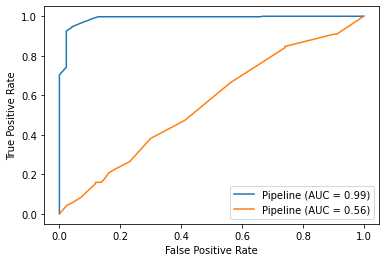

In [19]:
print(classification_report(y_test, y_pred))
print(pd.DataFrame(y_pred).value_counts())
ax = plt.gca()
plot_roc_curve(pipeline, X_train, y_train, ax=ax)
plot_roc_curve(pipeline, X_test, y_test, ax=ax);

### Deep learning approach

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [51]:
class Net(nn.Module):
    def __init__(self, n_input):
        super().__init__()
        self.fc1 = nn.Linear(n_input, 512)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 128)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(128, 1)
        #self.out_act = nn.Sigmoid()
        
    def forward(self,input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        y = self.out(h2)
        #y = self.out_act(y)
        return y
        
    #This function takes an input and predicts the class, (0 or 1)        
    def predict(self,x):
        pred = F.sigmoid(self.forward(x))
        # turn into binary classification 0 1
        pred = (torch.sign(pred - 0.5)+1)/2
        pred = pred.cpu().detach().numpy()
        return pred

In [52]:
def train_epoch(X, Y, model, opt, criterion, batch_size=2000):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size]
        x_batch = torch.autograd.Variable(x_batch)
        y_batch = torch.autograd.Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch.float().unsqueeze(1))
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.item())
    return losses

In [53]:
#Initialize the model        
model = Net(n_input=X_train.shape[1]).cuda()
#Define loss criterion
criterion = nn.BCEWithLogitsLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [54]:
X = torch.tensor(X_train).to(device='cuda')
y = torch.tensor(y_train.values).to(device='cuda')

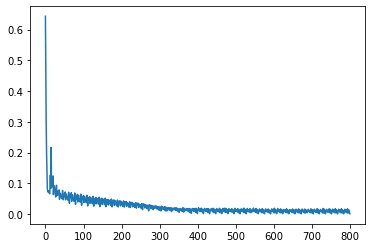

In [55]:
e_losses = []
num_epochs = 50
for e in range(num_epochs):
    e_losses += train_epoch(X, y, model, optimizer, criterion)
plt.plot(e_losses);

In [56]:
y_pred = model.predict(torch.tensor(X_test).to(device='cuda'))

In [83]:
y_test

29520    0
31919    0
42456    0
17067    0
16727    0
        ..
12862    0
30556    0
29065    0
41681    0
23021    0
Name: RESPONSE, Length: 12889, dtype: int64

In [84]:
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12745
           1       0.00      0.00      0.00       144

    accuracy                           0.99     12889
   macro avg       0.49      0.50      0.50     12889
weighted avg       0.98      0.99      0.98     12889



In [85]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred, pos_label=2)
auc(fpr, tpr)

nan

In [86]:
fpr

array([0.        , 0.00100861, 1.        ])

In [87]:
tpr

array([nan, nan, nan])

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [11]:
mailout_test = pd.read_csv('./Data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [12]:
mailout_test_clean = af.clean_df(mailout_test, imputer, azdias_cols_to_drop)

In [14]:
mailout_test_predict = svm_model.predict(mailout_test_clean)

In [19]:
pd.DataFrame({'LNR': mailout_test['LNR'], 'RESPONSE': mailout_test_predict}).to_csv(path_or_buf='', index=False)

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0
...,...,...
42828,67615,0
42829,67938,0
42830,67942,0
42831,67949,0


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-0:-Get-to-Know-the-Data" data-toc-modified-id="Part-0:-Get-to-Know-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Part 0: Get to Know the Data</a></span><ul class="toc-item"><li><span><a href="#Fixing-the-categorical-variables-and-memory-usage" data-toc-modified-id="Fixing-the-categorical-variables-and-memory-usage-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fixing the categorical variables and memory usage</a></span></li><li><span><a href="#Ranking-customers-labels" data-toc-modified-id="Ranking-customers-labels-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ranking customers labels</a></span></li><li><span><a href="#Cleanup-of-incomplete-data-(missing-values)" data-toc-modified-id="Cleanup-of-incomplete-data-(missing-values)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Cleanup of incomplete data (missing values)</a></span></li><li><span><a href="#Impute-the-missing-values" data-toc-modified-id="Impute-the-missing-values-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Impute the missing values</a></span></li></ul></li><li><span><a href="#Part-1:-Customer-Segmentation-Report" data-toc-modified-id="Part-1:-Customer-Segmentation-Report-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part 1: Customer Segmentation Report</a></span></li><li><span><a href="#Part-2:-Supervised-Learning-Model" data-toc-modified-id="Part-2:-Supervised-Learning-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part 2: Supervised Learning Model</a></span><ul class="toc-item"><li><span><a href="#Linear-support-vector-(for-comparison)" data-toc-modified-id="Linear-support-vector-(for-comparison)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear support vector (for comparison)</a></span></li><li><span><a href="#Balanced-Random-Forest-Classifier" data-toc-modified-id="Balanced-Random-Forest-Classifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Balanced Random Forest Classifier</a></span></li><li><span><a href="#Deep-learning-approach" data-toc-modified-id="Deep-learning-approach-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Deep learning approach</a></span></li></ul></li><li><span><a href="#Part-3:-Kaggle-Competition" data-toc-modified-id="Part-3:-Kaggle-Competition-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Part 3: Kaggle Competition</a></span></li></ul></div>